In [1]:
%load_ext autoreload
%autoreload 2
from baboo.simulation import TwoComponentModelSim, OneComponentModelSim
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('meyers_latex.mplstyle')
from matplotlib import rcParams
rcParams['text.latex.preamble'] = r'\newcommand{\mathdefault}[1][]{}'
plt.style.use('/fred/oz022/pmm_pulsar/state_space_pulsar_inference/state_space_inference/meyers_latex.mplstyle')
from baboo.utils import write_tim_file, write_par
import libstempo
import seaborn as sns
from scipy.stats import gaussian_kde


Bad key "hist.edgecolor" on line 47 in
/fred/oz022/pmm_pulsar/state_space_pulsar_inference/state_space_inference/meyers_latex.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "hatch.alpha" on line 49 in
/fred/oz022/pmm_pulsar/state_space_pulsar_inference/state_space_inference/meyers_latex.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution


# Single-component neutron star model

In this notebook we show you how to simulate a set of TOAs for the **single component** neutron star model, and get out a list of time-ordered frequencies obtained by fitting 3 TOAs at a time with `libstempo`. 

We then perform Bayesian inference to estimate the parameters of this model.

In this "single component" model we just have a rigid star spinning down, with start frequrency $f_0$ and frequency derivative $\dot{f}_0$. There is white noise added to the frequency derivative, which, in typical pulsar timing parlance, corresponds to a red-noise process of $f^{-4}$ in the phase (or timing) residuals.


# Simulate TOAs

First we simulate arrival times using our model.


In [2]:
# p0 depends on model you're using
# This is a one-component model that we will be considering
# so 0 => phase, 15 => initial frequency, -1e-10 => initial spindown
F2 = 0.
F1 = -1e-10
F0 = 15.
Qf=1e-24
p0=[0., F0, F1]

In [3]:
Ndays = 300 # number of days
Ntoas = 300 # number of TOAs to generate
toa_errors = 1e-4 * np.ones(Ntoas) # error on TOAs, 100 microseconds (typical for UTMOST telescope)

# generate Ndays, then randomly choose Ntoa values from them. sort it so they're in order.
# times = np.sort(np.random.choice(np.arange(Ndays*10.)/10., size=Ntoas, replace=False)).astype(float)

times = np.sort(np.random.choice(np.arange(Ndays), size=Ntoas, replace=False)).astype(float)
# print(times)
# create model
model_class_instantiation = OneComponentModelSim(Q_f1=Qf, F2=F2)
# print out A matrix
print(model_class_instantiation.F)
# integrate
# we toas, toa_errors, and then states (other than phase)
# toas, toa_errors, states = model_class_instantiation.integrate(times.copy(), p0=p0, toa_errors=toa_errors)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]


In [4]:
toas, toa_errors, times_fit, freqs, freq_errors, states =\
    model_class_instantiation.integrate_and_return_frequencies(times, F0, F1,
                                                               times[0], p0=p0,
                                                               toa_errors=toa_errors, Ntoas_per_fit=3)

100%|██████████| 297/297 [00:16<00:00, 12.41it/s]


# Check frequencies

Here we compare our estimated frequencies from ``libstempo`` to the "true" frequencies output from out stochastic integrator. We have set it up so they should both be evaluated at the same time.

If the noise process is not significant over the time-span of 3 ToAs, then these frequencies should be very close. However, if the noise process *is* significant on that time-scale, then we might see deviation between the "true" and the "estimated" frequencies. It's clear from the plot below that, for now, we have estimated the frequencies correctly and the red noise process is not significant on our 3 ToA time-scale.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


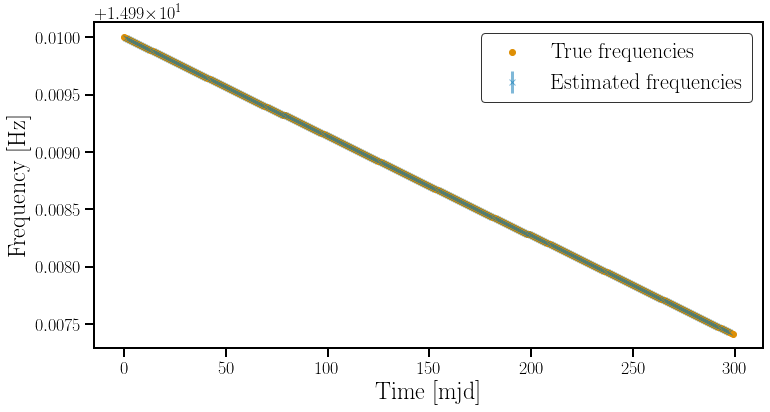

In [5]:
plt.figure(figsize=(12,6))
plt.errorbar(times_fit, freqs, yerr=freq_errors, fmt='x', alpha=0.5,label='Estimated frequencies')
plt.xlabel('Time [mjd]')
plt.ylabel('Frequency [Hz]')
plt.scatter(toas, states[0, :], c='C1', label='True frequencies')
plt.legend()

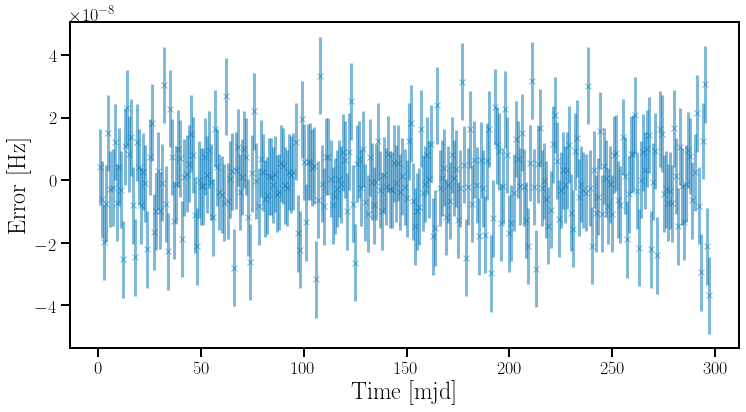

In [6]:
plt.figure(figsize=(12,6))
plt.xlabel('Time [mjd]')
plt.ylabel('Error [Hz]')
plt.errorbar(times_fit, (freqs - states[0, 1:-2]), yerr=freq_errors, fmt='x', alpha=0.5)
plt.show()

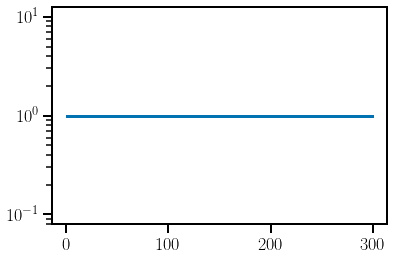

In [7]:
plt.plot(times[1:], np.diff(times))
plt.yscale('log')
plt.show()

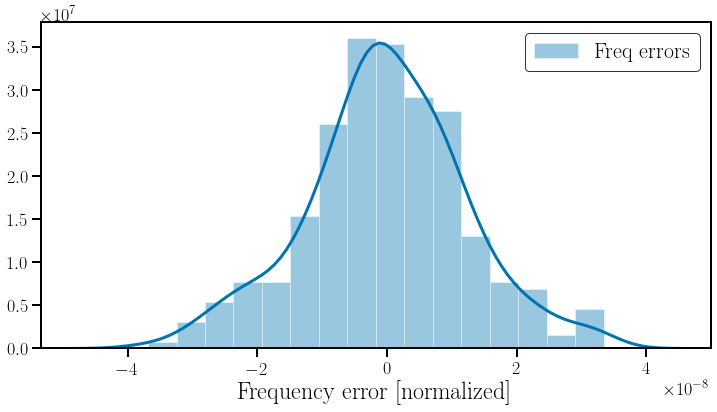

-10.378561641293285878


In [8]:
plt.figure(figsize=(12,6))
sns.distplot((freqs - states[0, 1:-2]), hist_kws={'edgecolor':'w'}, label='Freq errors')
# sns.distplot(np.random.randn(10000), hist=False, label='Gaussian [not a fit]')
# import scipy.stats as ss
# plt.plot(np.linspace(-4, 4, num=100), ss.norm.pdf(np.linspace(-4, 4, num=100)), label='Gaussian [not a fit]')
plt.legend()
plt.xlabel('Frequency error [normalized]')
plt.show()
print(np.log10(np.std((freqs - states[0, 1:-2]) / np.sqrt(86400))))

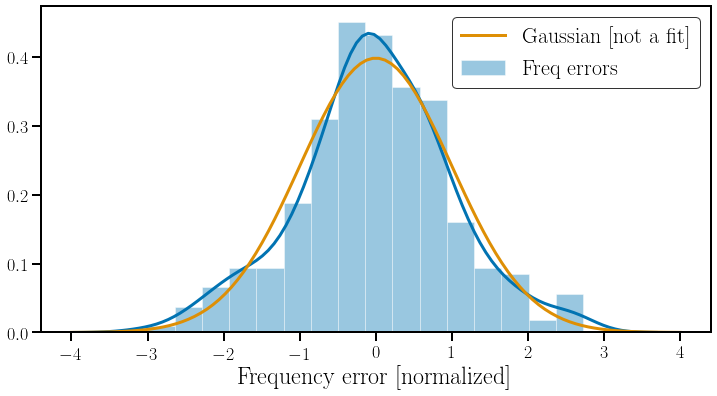

In [9]:
plt.figure(figsize=(12,6))
sns.distplot((freqs - states[0, 1:-2]) / freq_errors, hist_kws={'edgecolor':'w'}, label='Freq errors')
# sns.distplot(np.random.randn(10000), hist=False, label='Gaussian [not a fit]')
import scipy.stats as ss
plt.plot(np.linspace(-4, 4, num=100), ss.norm.pdf(np.linspace(-4, 4, num=100)), label='Gaussian [not a fit]')
plt.legend()
plt.xlabel('Frequency error [normalized]')
plt.show()

# Write ``tim`` and ``par`` files and run ``TEMPO2`` fitting on TOAs

In this case, we have added red noise, so the TOAs will not look white if we fit with TEMPO2/libstempo

In [10]:
Nsave = toas.size
write_tim_file('test', toas[:Nsave], 1e-4 * np.ones(Nsave))

In [11]:
PEPOCH = np.mean(toas[0])

F0_new = F0 + F1 * (PEPOCH - toas[0]) + F2 * (PEPOCH - toas[0])**2/2
F1_new = F1  + F2 * (PEPOCH - toas[0])
print(F0_new, F1_new)

15.0 -1.00000000000000003643e-10


In [12]:
# write_par('test', p0[1], p0[2], toas[0])
# %pycat test.par
with open("test.par", 'w') as myf:
    print(f"{'PSRJ':15}FAKE", file=myf)
    print(f"{'RAJ':15}0", file=myf)
    print(f"{'DECJ':15}0", file=myf)
    print(f"{'F0':15}{F0_new} 1  1e-3", file=myf)
    print(f"{'F1':15}{F1_new:.10e} 1 1e-5", file=myf)
    print(f"{'F2':15}{F2:.10e} 1 1e-26  ", file=myf)
    print(f"{'PEPOCH':15}{PEPOCH}", file=myf)
    print("TRACK -2", file=myf)

In [13]:
out = libstempo.tempopulsar(timfile='test.tim', parfile='test.par')
out.fit(iters=50)

(array([-3.40736748e-05,  1.50000000e+01, -9.99989142e-11, -7.11609543e-23]),
 array([2.28083165e-05, 1.14882865e-10, 2.06871971e-17, 1.57902747e-24]),
 array([[ 5.20219303e-10,  2.26161109e-15, -3.49594444e-22,
          2.36424240e-29],
        [ 2.26161109e-15,  1.31980728e-20, -2.30028623e-27,
          1.66120796e-34],
        [-3.49594444e-22, -2.30028623e-27,  4.27960125e-34,
         -3.22058159e-41],
        [ 2.36424240e-29,  1.66120796e-34, -3.22058159e-41,
          2.49332775e-48]]),
 549.54195264644051405)

In [14]:
print(out['F0'])
print(out['F1'])
print(out['F2'])

tempo2 parameter F0 (fitted): 14.999999997563508103 +/- 1.1488286545214059457e-10
tempo2 parameter F1 (fitted): -9.999891422972039631e-11 +/- 2.0687197137007123604e-17
tempo2 parameter F2 (fitted): -7.116095432961338955e-23 +/- 1.5790274682671432704e-24


Text(0, 0.5, 'TOA residual')

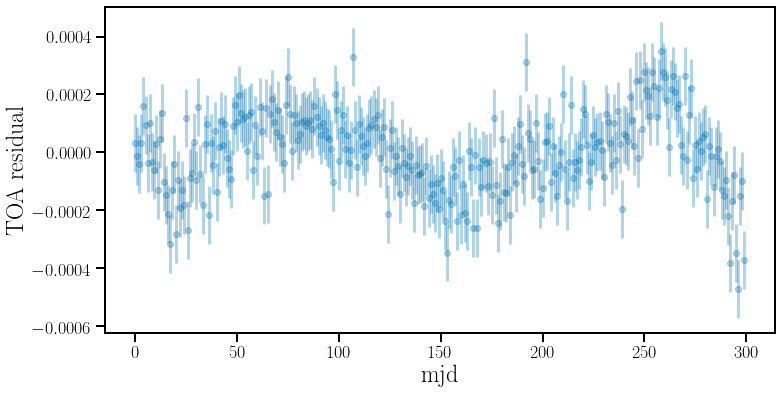

In [15]:
plt.figure(figsize=(12,6))
plt.errorbar(out.toas(), out.residuals(), yerr=1e-4 * np.ones(Ntoas), fmt='o', alpha=0.3)
plt.xlabel('mjd')
plt.ylabel('TOA residual')

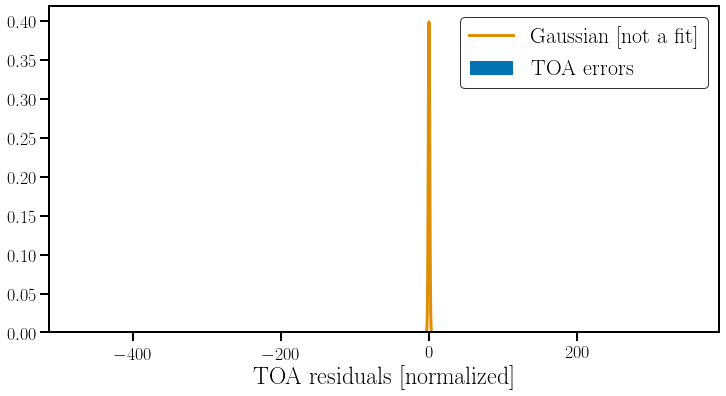

In [16]:
plt.figure(figsize=(12,6))
plt.hist(out.residuals() / 1e-6, edgecolor='w', density=True, label='TOA errors', bins=25)
plt.plot(np.linspace(-4, 4, num=100), ss.norm.pdf(np.linspace(-4, 4, num=100)), label='Gaussian [not a fit]')
plt.legend()
plt.xlabel('TOA residuals [normalized]')
plt.show()

# Inference on single component model

Now we run inference on the single component model, trying to estimate the parameters of the system. In this case, we assume that we have only **frequency** measurements (that is, the `freqs` variable from above).

In [17]:
from baboo.models import OneComponentModel
from baboo.sample import KalmanLikelihoodOneComponent
import bilby
from corner import corner

In [18]:
mycov = np.asarray([[freq_errors[ii]**2] for ii in range(np.array(freq_errors).size)]).astype(float)
design = np.asarray([1.]).reshape([1,1])

model = OneComponentModel(np.array(freqs).astype(float).reshape((np.size(freqs), 1)), mycov, design,
                           86400*np.array(times_fit).astype(float))
likelihood = KalmanLikelihoodOneComponent(model)

In [19]:
p, V = np.polyfit((np.array(times_fit).astype(float) - times_fit[0])*86400, np.array(freqs).astype(float), 1, cov=True, w=1/np.array(freq_errors).astype(float))
F1_est = p[0]
F1err = 10000 * np.sqrt(V[0,0])
F0_est = p[1]
F0err = 10000 * np.sqrt(V[1,1])
print(F1_est, F1err)

priors = bilby.core.prior.PriorDict()
priors['sigma2'] = bilby.core.prior.LogUniform(minimum=1e-30, maximum=1e-12,
                    name='sigma2', latex_label='$\\sigma^2$/I^2')
priors['torque'] = bilby.core.prior.Uniform(minimum=F1_est - F1err,
                    maximum=F1_est + F1err, name='torque',
                    latex_label='$\\langle \\dot{\\Omega}_c \\rangle$')
priors['omgc_0'] = bilby.core.prior.Uniform(F0_est - F0err, F0_est + F0err, name='omgc_0',
                    latex_label='$\\Omega_{\\textrm{c}, 0}$')
priors['EFAC'] = bilby.core.prior.DeltaFunction(1, name='EFAC',
        latex_label='EFAC')
priors['EQUAD'] = bilby.core.prior.DeltaFunction(0, name='EQUAD',
        latex_label='EQUAD')

-9.99998145283079e-11 9.76079535340102e-13


In [20]:
# Sample
# Use a small number of livepoints now so it finishes quickly -- in the future we should use more.
result = bilby.run_sampler(likelihood, priors, sampler='dynesty', walks=10, npoints=200, resume=False, sample='rwalk_dynesty', bound='single', label='baboo_example_onecomp', outdir='general_noise_model')

18:38 bilby INFO    : Running for label 'baboo_example_onecomp', output will be saved to 'general_noise_model'
18:38 bilby INFO    : Search parameters:
18:38 bilby INFO    :   sigma2 = LogUniform(minimum=1e-30, maximum=1e-12, name='sigma2', latex_label='$\\sigma^2$/I^2', unit=None, boundary=None)
18:38 bilby INFO    :   torque = Uniform(minimum=-1.00975894063648e-10, maximum=-9.90237349929678e-11, name='torque', latex_label='$\\langle \\dot{\\Omega}_c \\rangle$', unit=None, boundary=None)
18:38 bilby INFO    :   omgc_0 = Uniform(minimum=14.999976936419383, maximum=15.000005786373656, name='omgc_0', latex_label='$\\Omega_{\\textrm{c}, 0}$', unit=None, boundary=None)
18:38 bilby INFO    :   EFAC = 1
18:38 bilby INFO    :   EQUAD = 0
18:38 bilby INFO    : Single likelihood evaluation took 4.852e-03 s


0it [00:00, ?it/s]

18:38 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'single', 'sample': 'rwalk_dynesty', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 200, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 120, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fe0b4b59630>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
18:38 bilby INFO    : Checkpoint every check_point_delta_t = 600s
18:38 bilby INFO    : Using dynesty version 1.0.1
18:38 bilby INFO    : Generating initial points from

370it [00:07, 38.74it/s, bound:0 nc:  7 ncall:1.2e+03 eff:30.7% logz=3907.51+/-0.27 dlogz:972.396>0.1]     

18:38 bilby INFO    : Written checkpoint file general_noise_model/baboo_example_onecomp_resume.pickle
18:38 bilby WARNING : singular matrix
18:38 bilby WARNING : Failed to create dynesty state plot at checkpoint
/fred/oz022/xray_gw_work/conda_env/gwxray3/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
18:38 bilby WARNING : singular matrix
18:38 bilby WARNING : Failed to create dynesty run plot at checkpoint


1098it [01:04, 15.67it/s, bound:35 nc: 33 ncall:1.2e+04 eff:8.8% logz=4723.79+/-0.29 dlogz:235.397>0.1]

/fred/oz022/xray_gw_work/conda_env/gwxray3/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "


3276it [03:19, 18.85it/s, bound:231 nc:  1 ncall:3.8e+04 eff:8.6% logz=4950.99+/-0.36 dlogz:0.099>0.1] 

18:41 bilby INFO    : Written checkpoint file general_noise_model/baboo_example_onecomp_resume.pickle
18:41 bilby INFO    : Writing 584 current samples to general_noise_model/baboo_example_onecomp_samples.dat
/fred/oz022/xray_gw_work/conda_env/gwxray3/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/fred/oz022/xray_gw_work/conda_env/gwxray3/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
18:42 bilby WARNING : Axis limits cannot be NaN or Inf
18:42 bilby WARNING : Failed to create dynesty run plot at checkpoint


18:42 bilby INFO    : Sampling time: 0:03:17.243024
18:42 bilby INFO    : Summary of results:
nsamples: 3476
ln_noise_evidence:    nan
ln_evidence: 4951.082 +/-  0.358
ln_bayes_factor:    nan +/-  0.358



(3476, 3)
(3476, 3)


<function matplotlib.pyplot.show(*args, **kw)>

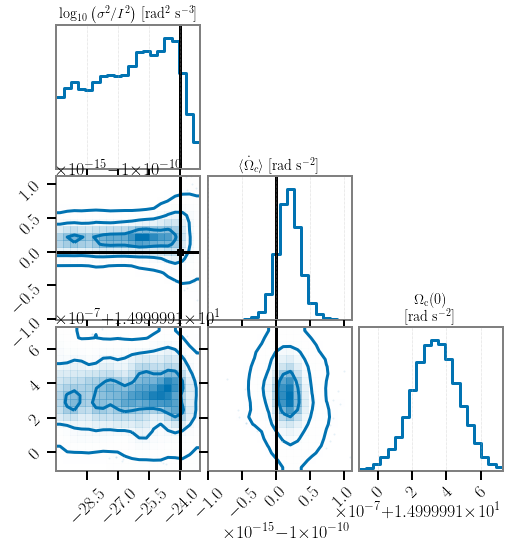

In [21]:
samples = result.posterior.to_numpy()[:, :3].copy()
print(samples.shape)
# make samples log10 for easier viewing
samples[:, 0] = np.log10(samples[:, 0]) #+ np.log10(2)
print(samples.shape)

# corner plot of results
from corner import corner
labels = ['$\\log_{10}\\left(\\sigma^2/I^2\\right)$ $[\\rm{rad^2~s^{-3}}]$',
          '$\\langle \\dot\\Omega_c\\rangle$ $[\\rm{rad~s^{-2}}]$',
          '$\Omega_{\\rm{c}}(0)$\n$[\\rm{rad~s^{-2}}]$']# ,
 #          '$\\log_{10}\,\\rm{EFAC}$', '$\\log_{10}\,\\rm{EQUAD}$']
fig = corner(samples, color='C0', smooth=True, smooth1d=True,
             levels=[1-np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9/2)],
            truths=[np.log10(Qf), F1, F0], truth_color='k')
axarr = np.reshape(fig.axes, (len(labels), len(labels)))
for ii, label in enumerate(labels):
    axarr[ii,ii].set_title(label)
plt.show

# Summary

We can see that we get a good estimate of the spindown, and the noise is peaked in the correct place.

In [22]:
mycov = np.asarray([[freq_errors[ii]**2] for ii in range(np.array(freq_errors).size)]).astype(float)
design = np.asarray([1.]).reshape([1,1])

model = OneComponentModel(np.array(states[0, 1:-2]).astype(float).reshape((np.size(freqs), 1)), mycov, design,
                           86400*np.array(times_fit).astype(float))
likelihood = KalmanLikelihoodOneComponent(model)

In [23]:
p, V = np.polyfit((np.array(times_fit).astype(float) - times_fit[0])*86400, np.array(freqs).astype(float), 1, cov=True, w=1/np.array(freq_errors).astype(float))
F1_est = p[0]
F1err = 10000 * np.sqrt(V[0,0])
F0_est = p[1]
F0err = 10000 * np.sqrt(V[1,1])
print(F1_est, F1err)

priors = bilby.core.prior.PriorDict()
priors['sigma2'] = bilby.core.prior.LogUniform(minimum=1e-30, maximum=1e-12,
                    name='sigma2', latex_label='$\\sigma^2$/I^2')
priors['torque'] = bilby.core.prior.Uniform(minimum=F1_est - F1err,
                    maximum=F1_est + F1err, name='torque',
                    latex_label='$\\langle \\dot{\\Omega}_c \\rangle$')
priors['omgc_0'] = bilby.core.prior.Uniform(F0_est - F0err, F0_est + F0err, name='omgc_0',
                    latex_label='$\\Omega_{\\textrm{c}, 0}$')
priors['EFAC'] = bilby.core.prior.DeltaFunction(1, name='EFAC',
        latex_label='EFAC')
priors['EQUAD'] = bilby.core.prior.DeltaFunction(0, name='EQUAD',
        latex_label='EQUAD')

-9.99998145283079e-11 9.76079535340102e-13


In [24]:
# Sample
# Use a small number of livepoints now so it finishes quickly -- in the future we should use more.
result2 = bilby.run_sampler(likelihood, priors, sampler='dynesty', walks=10, npoints=200, resume=False, sample='rwalk_dynesty', bound='single', label='baboo_example_onecomp_alt', outdir='general_noise_model')

18:42 bilby INFO    : Running for label 'baboo_example_onecomp_alt', output will be saved to 'general_noise_model'
18:42 bilby INFO    : Search parameters:
18:42 bilby INFO    :   sigma2 = LogUniform(minimum=1e-30, maximum=1e-12, name='sigma2', latex_label='$\\sigma^2$/I^2', unit=None, boundary=None)
18:42 bilby INFO    :   torque = Uniform(minimum=-1.00975894063648e-10, maximum=-9.90237349929678e-11, name='torque', latex_label='$\\langle \\dot{\\Omega}_c \\rangle$', unit=None, boundary=None)
18:42 bilby INFO    :   omgc_0 = Uniform(minimum=14.999976936419383, maximum=15.000005786373656, name='omgc_0', latex_label='$\\Omega_{\\textrm{c}, 0}$', unit=None, boundary=None)
18:42 bilby INFO    :   EFAC = 1
18:42 bilby INFO    :   EQUAD = 0
18:42 bilby INFO    : Single likelihood evaluation took 4.781e-03 s


0it [00:00, ?it/s]

18:42 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'single', 'sample': 'rwalk_dynesty', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 200, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 120, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fe0b455eeb8>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
18:42 bilby INFO    : Checkpoint every check_point_delta_t = 600s
18:42 bilby INFO    : Using dynesty version 1.0.1
18:42 bilby INFO    : Generating initial points from

342it [00:06, 29.17it/s, bound:0 nc:  9 ncall:1.2e+03 eff:28.5% logz=3893.44+/-0.28 dlogz:1060.794>0.1]    

18:42 bilby INFO    : Written checkpoint file general_noise_model/baboo_example_onecomp_alt_resume.pickle
/fred/oz022/xray_gw_work/conda_env/gwxray3/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/fred/oz022/xray_gw_work/conda_env/gwxray3/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
18:42 bilby WARNING : Axis limits cannot be NaN or Inf
18:42 bilby WARNING : Failed to create dynesty run plot at checkpoint


3335it [03:13, 19.77it/s, bound:238 nc: 10 ncall:3.7e+04 eff:8.9% logz=5100.04+/-0.36 dlogz:0.100>0.1] 

18:45 bilby INFO    : Written checkpoint file general_noise_model/baboo_example_onecomp_alt_resume.pickle
18:45 bilby INFO    : Writing 547 current samples to general_noise_model/baboo_example_onecomp_alt_samples.dat
/fred/oz022/xray_gw_work/conda_env/gwxray3/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/fred/oz022/xray_gw_work/conda_env/gwxray3/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
18:45 bilby WARNING : Axis limits cannot be NaN or Inf
18:45 bilby WARNING : Failed to create dynesty run plot at checkpoint


18:45 bilby INFO    : Sampling time: 0:03:11.775187
18:45 bilby INFO    : Summary of results:
nsamples: 3535
ln_noise_evidence:    nan
ln_evidence: 5100.136 +/-  0.362
ln_bayes_factor:    nan +/-  0.362



(3476, 3)
(3535, 3)


<function matplotlib.pyplot.show(*args, **kw)>

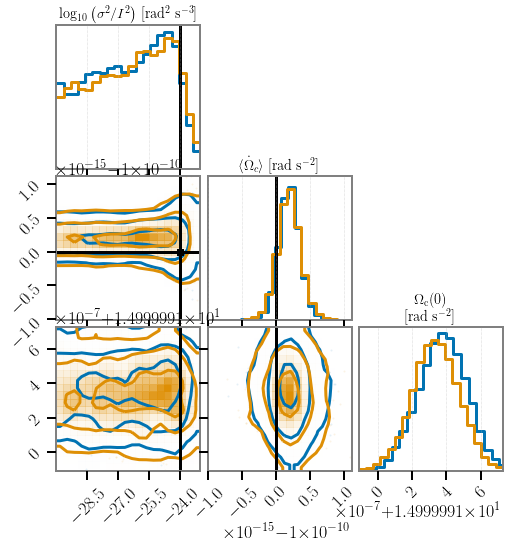

In [25]:
samples2 = result2.posterior.to_numpy()[:, :3].copy()
print(samples.shape)
# make samples log10 for easier viewing
samples2[:, 0] = np.log10(samples2[:, 0]) #+ np.log10(2)
print(samples2.shape)

# corner plot of results
from corner import corner
labels = ['$\\log_{10}\\left(\\sigma^2/I^2\\right)$ $[\\rm{rad^2~s^{-3}}]$',
          '$\\langle \\dot\\Omega_c\\rangle$ $[\\rm{rad~s^{-2}}]$',
          '$\Omega_{\\rm{c}}(0)$\n$[\\rm{rad~s^{-2}}]$']# ,
 #          '$\\log_{10}\,\\rm{EFAC}$', '$\\log_{10}\,\\rm{EQUAD}$']
fig = corner(samples2, color='C0', smooth=True, smooth1d=True,
             levels=[1-np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9/2)],
            truths=[np.log10(Qf), F1, F0], truth_color='k')
corner(samples[:samples2.shape[0], :], color='C1', smooth=True, smooth1d=True, levels=[1-np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9/2)],
            truths=[np.log10(Qf), F1, F0], truth_color='k', fig=fig)
axarr = np.reshape(fig.axes, (len(labels), len(labels)))
for ii, label in enumerate(labels):
    axarr[ii,ii].set_title(label)
plt.show

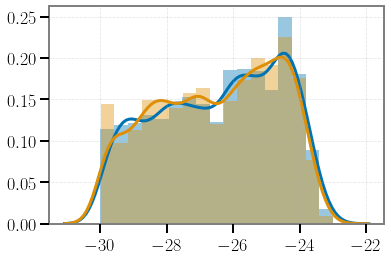

In [26]:
sns.distplot(samples[:, 0])
sns.distplot(samples2[:, 0])
plt.show()